In [13]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import logging
import seaborn as sns
from pathlib import Path
logging.getLogger('matplotlib.font_manager').disabled = True
import os

In [14]:
data_type = 'hourly_avg_clustering'

In [15]:
key_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/00_SWW_ID_smartmeter.xlsx"
key_df = pd.read_excel(key_path, header=None)

# Load the Excel file
file_path = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/Survey_Data/Survey_Data.xlsx"
# Read without headers, so columns are numbered 0,1,2,...
df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None)

# Now columns 10 and 131 correspond to Excel columns K and Q exactly (0-based)
cols_to_extract = [10, 131, 127, 130, 143, 144, 145, 146, 128, 147, 129, 28]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['house-id', 'tenant type', 'age', 'building type', 'solar panels', 'heat pump', 'electric vehicle', 'electric water heating', 'monthly income', 'number of residents', 'education level', 'days at home']

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_house_ids = extracted_df_pl["house-id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique house-id count: {unique_house_ids}")

if total_rows > unique_house_ids:
    print(f"There are {total_rows - unique_house_ids} duplicate house_id entries.")
else:
    print("No duplicates found in house_id column.")

#print(extracted_df)

# Save extracted columns to a new Excel or CSV file if needed

#extracted_df.to_csv("extracted_columns.csv", index=False)

Total rows: 1500
Unique house-id count: 1500
No duplicates found in house_id column.


In [16]:

# Column 1 (index 0) has original house IDs, column 2 (index 1) has CH... identifiers
# Create a mapping dict: {house_id: CH_id}
mapping = dict(zip(key_df.iloc[:,0], key_df.iloc[:,2]))

# Map 'house-id' in extracted_df to 'CH...' values
# Safely assign new column using .loc to avoid SettingWithCopyWarning
extracted_df = extracted_df.copy()
extracted_df['CH_id'] = extracted_df['house-id'].map(mapping)

#print(extracted_df)


In [17]:
result_df = pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{data_type}.csv')

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv") 

# Normalize keys in all DataFrames for clean join
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_total_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2)
]).sort("cluster")

print(cluster_summary)

shape: (4, 4)
┌─────────┬────────────────┬─────────────────────────────┬─────────────────────────────┐
│ cluster ┆ num_households ┆ avg_total_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---     ┆ ---            ┆ ---                         ┆ ---                         │
│ i64     ┆ u32            ┆ f64                         ┆ f64                         │
╞═════════╪════════════════╪═════════════════════════════╪═════════════════════════════╡
│ 1       ┆ 464            ┆ 4702.35                     ┆ 8.21                        │
│ 2       ┆ 178            ┆ 7638.4                      ┆ 11.91                       │
│ 3       ┆ 161            ┆ 6227.39                     ┆ 10.78                       │
│ 4       ┆ 661            ┆ 2936.79                     ┆ 5.02                        │
└─────────┴────────────────┴─────────────────────────────┴─────────────────────────────┘


In [18]:
extracted_pl_df = pl.from_pandas(extracted_df)

print(extracted_pl_df.shape)

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

extracted_pl_df = extracted_pl_df.with_columns(
    pl.col("CH_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

# First join: attach survey columns
joined = result_df.join(
    extracted_pl_df.select([
        "ch_id_clean",
        "tenant type",
        "age",
        "building type",
        "solar panels",
        "heat pump",
        "electric vehicle",
        "electric water heating",
        "monthly income",
        "number of residents",
        "education level",
        "days at home"
    ]),
    on="ch_id_clean",
    how="left"
)

# Second join: attach consumption
joined = joined.join(
    alle_mittelwerte_df.select(["ch_id_clean", "bruttolastgang_kwh_sum"]),
    on="ch_id_clean",
    how="left"
)

# Now select in the desired order
final_df = joined.select([
    "house_id",                # Column 0
    "bruttolastgang_kwh_sum",  # Column 1
    "cluster",                 # Column 2
    "tenant type",
    "age",
    "building type",
    "solar panels",
    "heat pump",
    "electric vehicle",
    "electric water heating",
    "monthly income",
    "number of residents",
    "education level",
    "days at home"
])

print(final_df.head())

(1500, 13)
shape: (5, 14)
┌────────────┬────────────┬─────────┬────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ house_id   ┆ bruttolast ┆ cluster ┆ tenant ┆ … ┆ monthly    ┆ number of  ┆ education ┆ days at   │
│ ---        ┆ gang_kwh_s ┆ ---     ┆ type   ┆   ┆ income     ┆ residents  ┆ level     ┆ home      │
│ str        ┆ um         ┆ i64     ┆ ---    ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│            ┆ ---        ┆         ┆ str    ┆   ┆ str        ┆ f64        ┆ str       ┆ f64       │
│            ┆ f64        ┆         ┆        ┆   ┆            ┆            ┆           ┆           │
╞════════════╪════════════╪═════════╪════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ CH10186012 ┆ 1116.376   ┆ 1       ┆ Tenant ┆ … ┆ 4,000-5,99 ┆ 1.0        ┆ Tertiary  ┆ 4.0       │
│ 3450000000 ┆            ┆         ┆        ┆   ┆ 9          ┆            ┆ degree    ┆           │
│ 0000000112 ┆            ┆         ┆        ┆   ┆            ┆  

In [19]:
def categorize_consumption(value):
    if value < 5000:
        return "0-5 MWh"
    elif value < 10000:
        return "5-10 MWh"
    elif value < 15000:
        return "10-15 MWh"
    elif value < 20000:
        return "15-20 MWh"
    elif value < 25000:
        return "20-25 MWh"
    else:
        return "25+ MWh"

final_df = final_df.with_columns(
    pl.col("bruttolastgang_kwh_sum")
      .map_elements(categorize_consumption, return_dtype=pl.Utf8)
      .alias("consumption_category")
)

print(final_df.head())

final_df.write_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/hourly_avg_clustering_summer_category.csv")

print(final_df.shape)

shape: (5, 15)
┌────────────┬────────────┬─────────┬────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ house_id   ┆ bruttolast ┆ cluster ┆ tenant ┆ … ┆ number of  ┆ education  ┆ days at   ┆ consumpti │
│ ---        ┆ gang_kwh_s ┆ ---     ┆ type   ┆   ┆ residents  ┆ level      ┆ home      ┆ on_catego │
│ str        ┆ um         ┆ i64     ┆ ---    ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ry        │
│            ┆ ---        ┆         ┆ str    ┆   ┆ f64        ┆ str        ┆ f64       ┆ ---       │
│            ┆ f64        ┆         ┆        ┆   ┆            ┆            ┆           ┆ str       │
╞════════════╪════════════╪═════════╪════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ CH10186012 ┆ 1116.376   ┆ 1       ┆ Tenant ┆ … ┆ 1.0        ┆ Tertiary   ┆ 4.0       ┆ 0-5 MWh   │
│ 3450000000 ┆            ┆         ┆        ┆   ┆            ┆ degree     ┆           ┆           │
│ 0000000112 ┆            ┆         ┆        ┆   ┆            ┆ (Superior  ┆

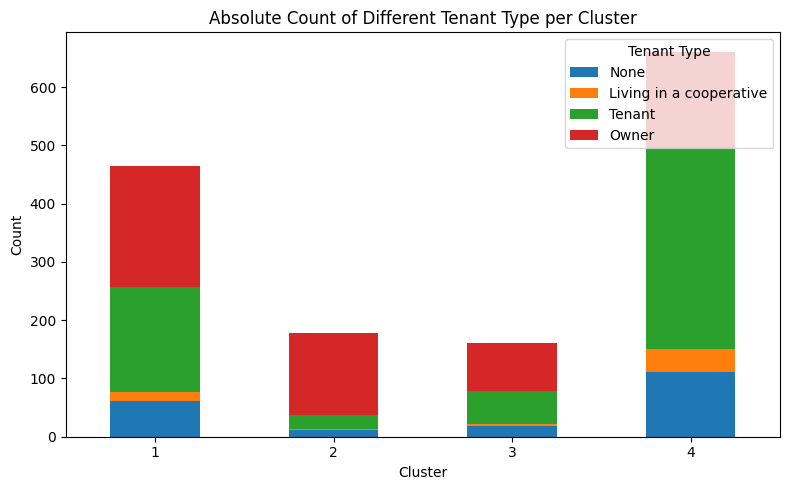

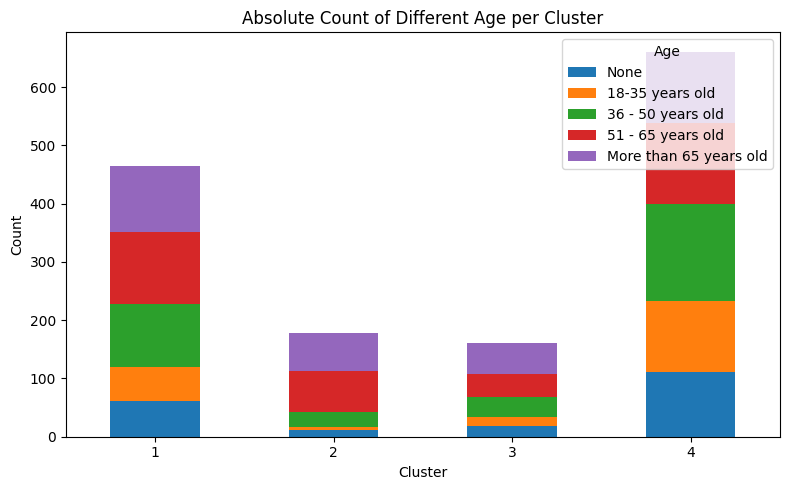

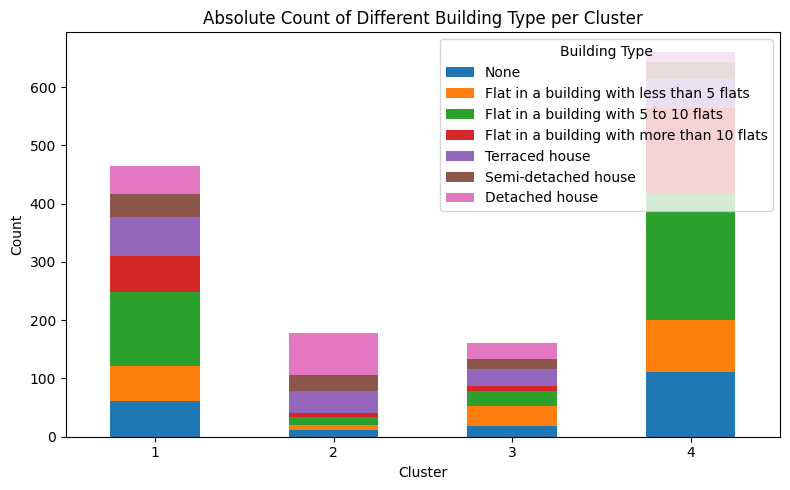

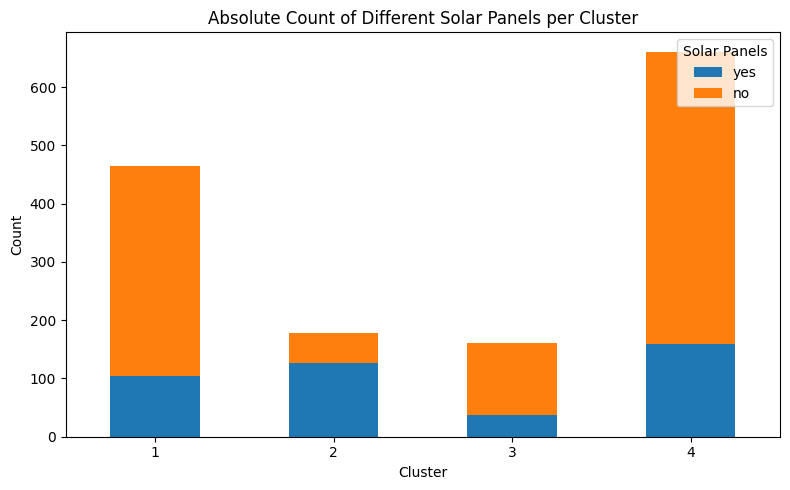

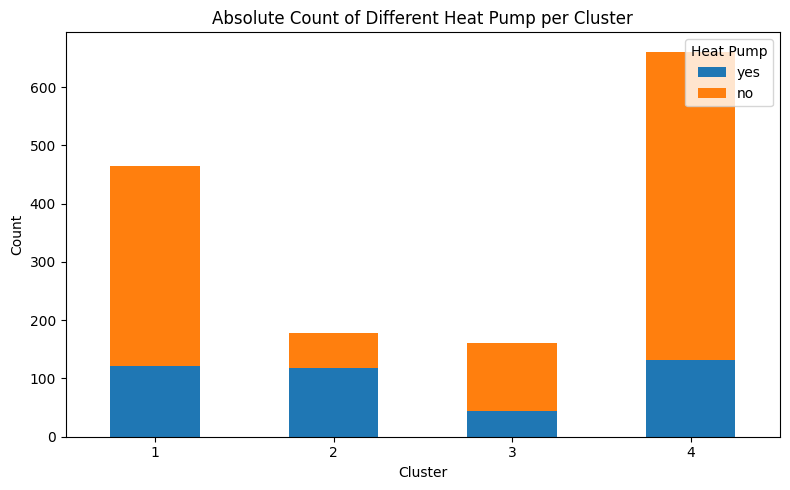

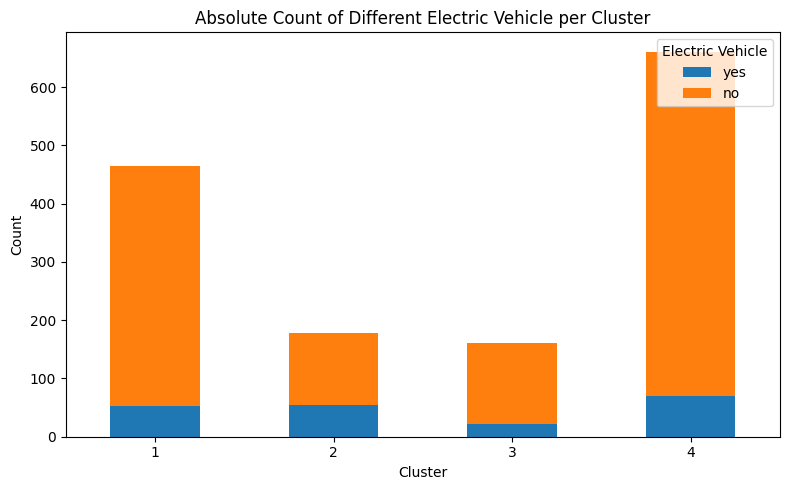

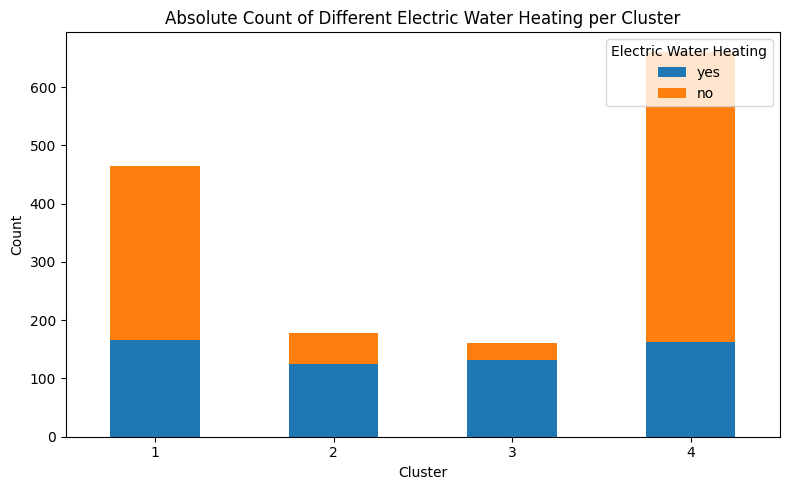

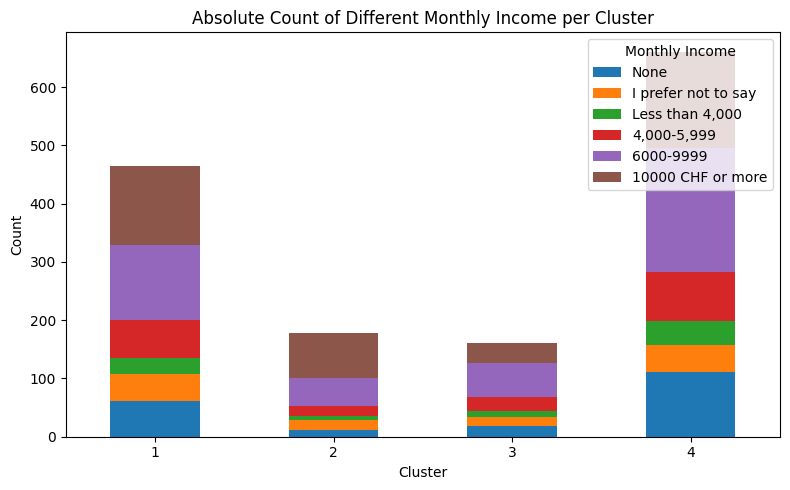

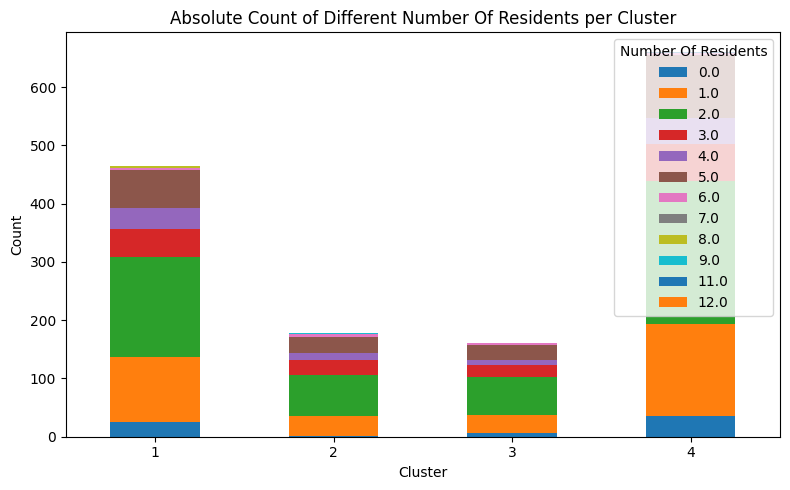

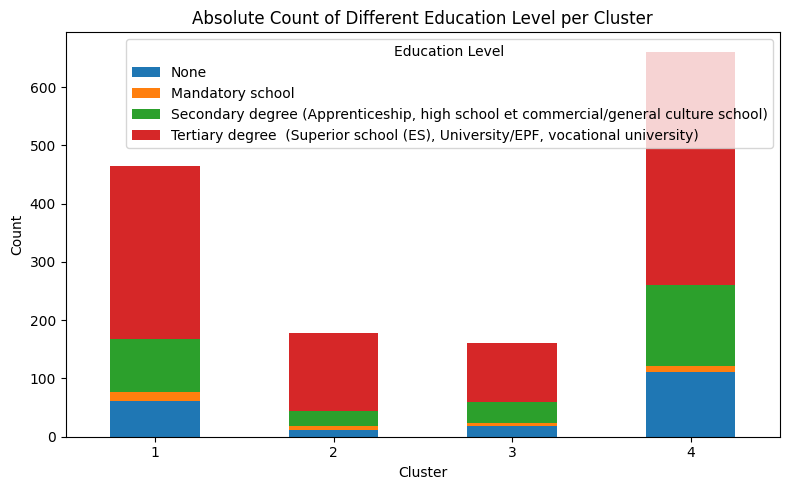

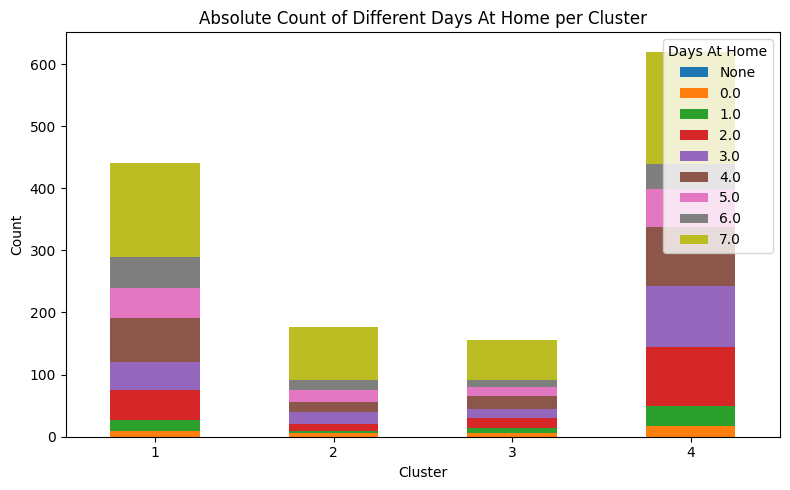

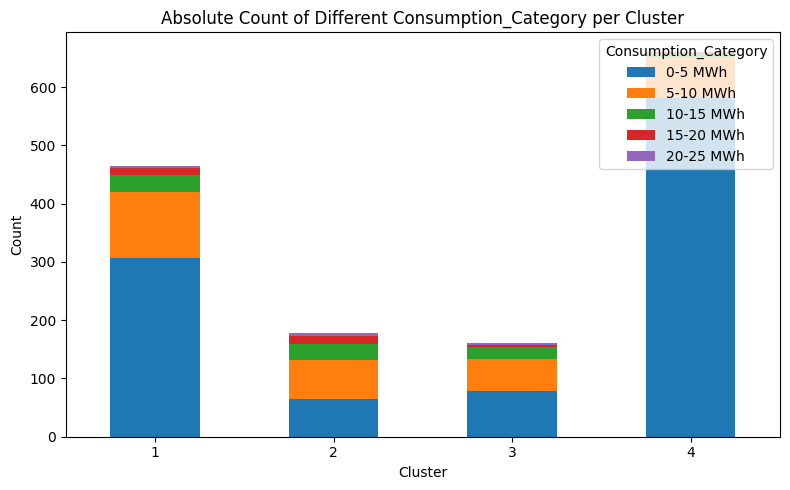

In [20]:
result_folder = Path(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/{data_type}/absolute')
result_folder.mkdir(parents=True, exist_ok=True)

final_df_absolute = final_df.to_pandas()
clusters = sorted(final_df_absolute['cluster'].unique())

cols = final_df_absolute.columns[2:]
category_columns = [col for col in cols if col != 'cluster']

custom_category_orders = {
    'tenant type': ['None', 'Living in a cooperative', 'Tenant', 'Owner'],
    'age': ['None', '18-35 years old', '36 - 50 years old', '51 - 65 years old', 'More than 65 years old'],
    'building type': ['None', 'Flat in a building with less than 5 flats', 'Flat in a building with 5 to 10 flats', 'Flat in a building with more than 10 flats','Terraced house','Semi-detached house','Detached house'],
    'solar panels': ['yes', 'no'],
    'heat pump': ['yes', 'no'],
    'electric vehicle': ['yes', 'no'],
    'electric water heating': ['yes', 'no'],
    'monthly income': ['None', 'I prefer not to say', 'Less than 4,000', '4,000-5,999','6000-9999','10000 CHF or more' ],
    'number of residents': ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '11.0', '12.0'],
    'consumption_category': ['0-5 MWh', '5-10 MWh', '10-15 MWh', '15-20 MWh', '20-25 MWh'],
    'education level': ['None','Mandatory school', 'Secondary degree (Apprenticeship, high school et commercial/general culture school)', 'Tertiary degree  (Superior school (ES), University/EPF, vocational university)'],
    'days at home': ['None','0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']
}

for col in category_columns:
    final_df_absolute[col] = final_df_absolute[col].astype(str)
    unique_cats = set(final_df_absolute[col].unique())

    fixed_category_order = custom_category_orders.get(col)
    if fixed_category_order is None:
        fixed_category_order = sorted(unique_cats)

    counts = {cat: [] for cat in fixed_category_order}

    for cl in clusters:
        cluster_subset = final_df_absolute[final_df_absolute['cluster'] == cl]
        for cat in fixed_category_order:
            count_cat = sum(cluster_subset[col] == cat)
            # Use count_cat directly for absolute values (not relative)
            counts[cat].append(count_cat)

    count_df = pd.DataFrame(counts, index=clusters)

    ax = count_df.plot(kind='bar', stacked=True, figsize=(8, 5))
    ax.set_title(f"Absolute Count of Different {col.title()} per Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")
    ax.legend(title=col.title(), loc='upper right')
    plt.xticks(rotation=0)
    plt.tight_layout()
    

    filename = f'{data_type}_{col}_absolute.png'
    full_path = os.path.join(result_folder, filename)

    plt.savefig(full_path)
    plt.show()

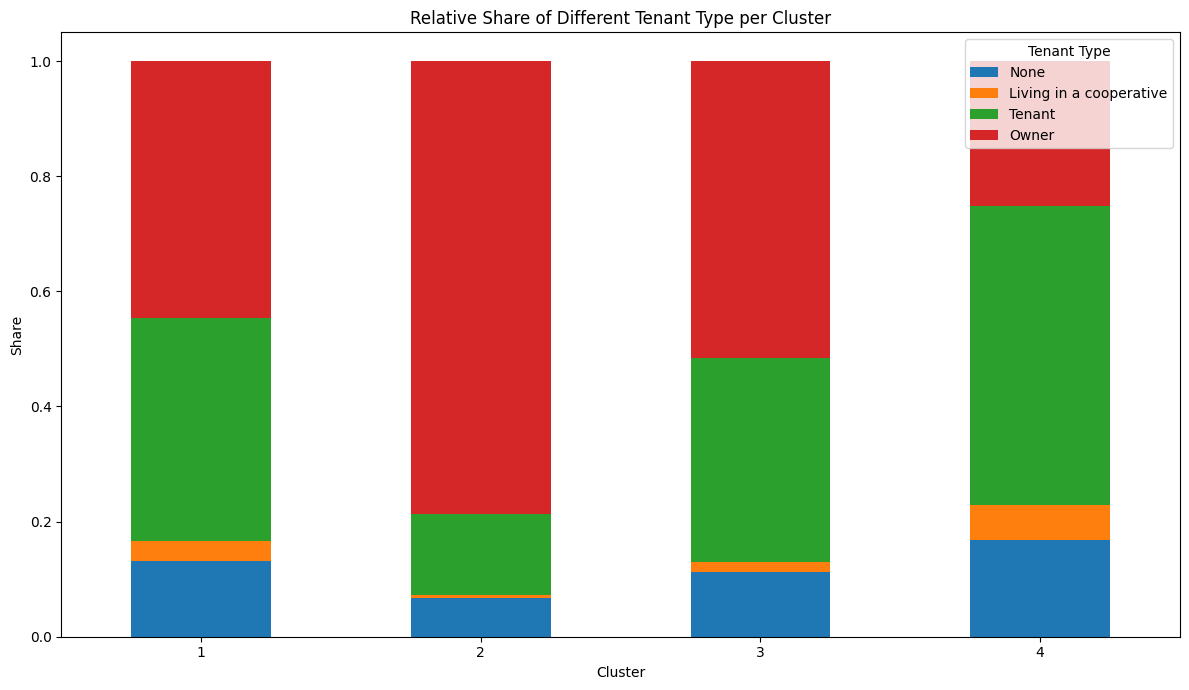

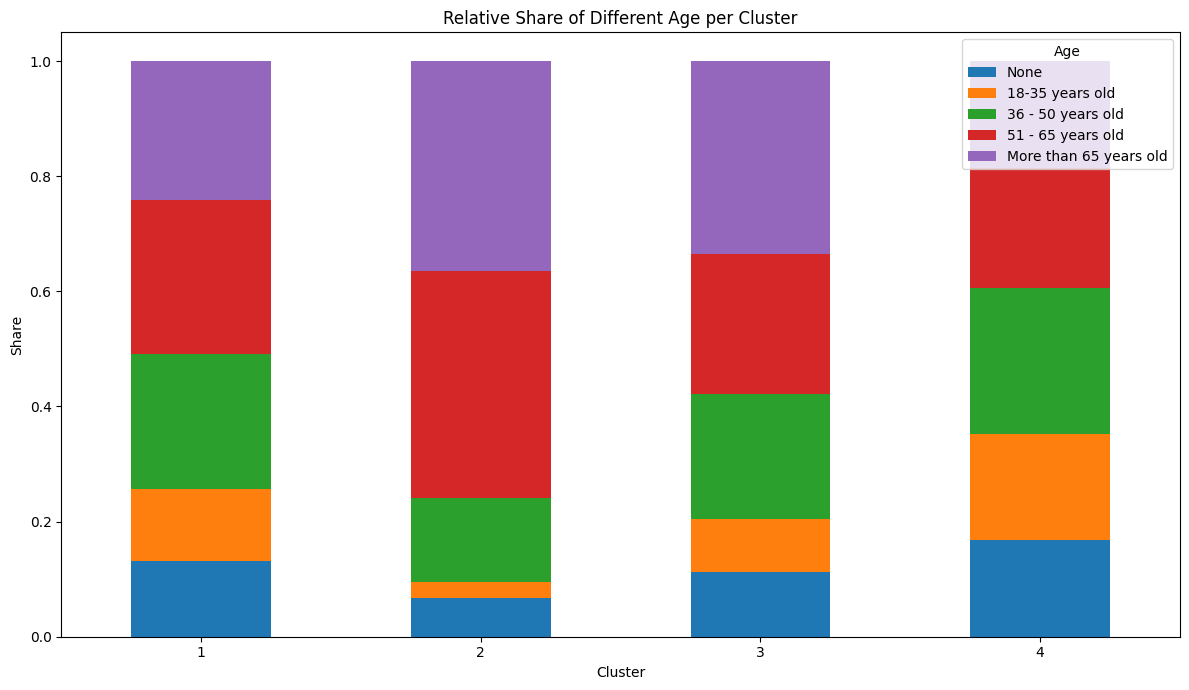

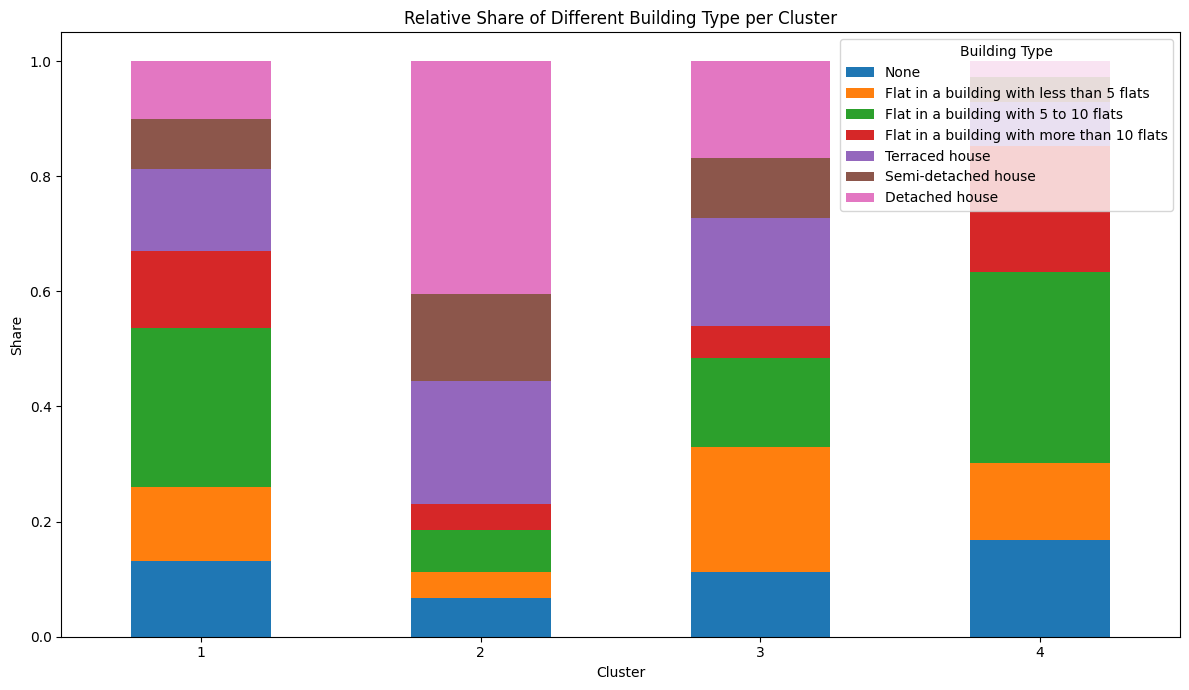

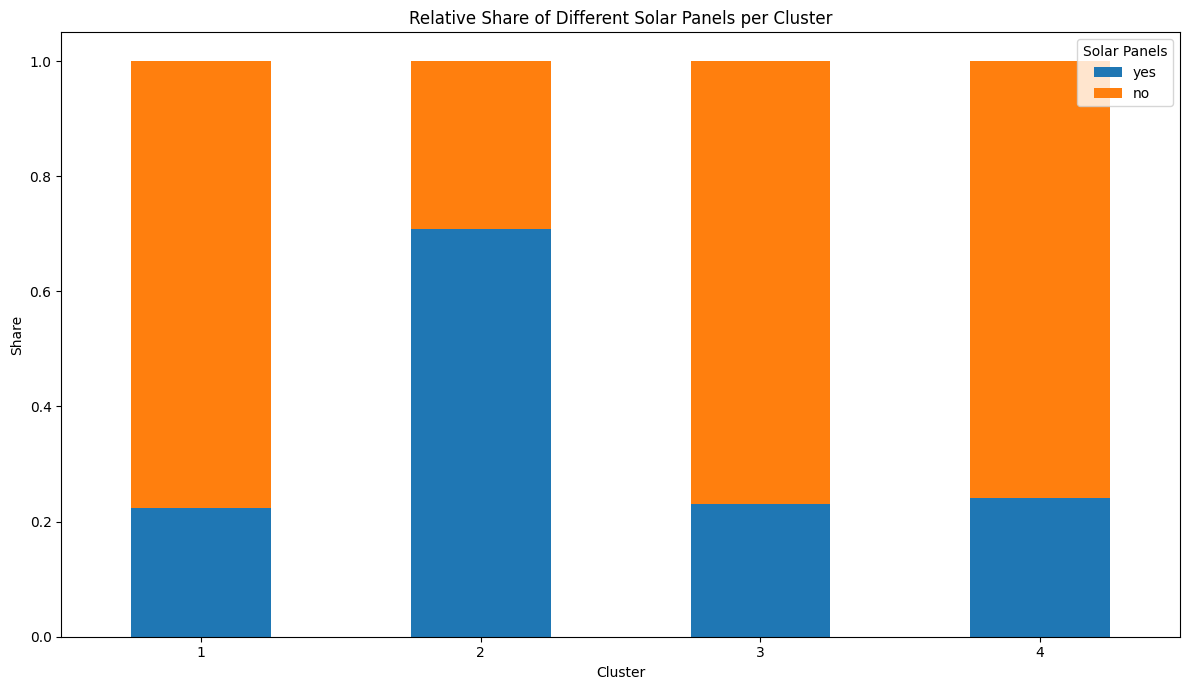

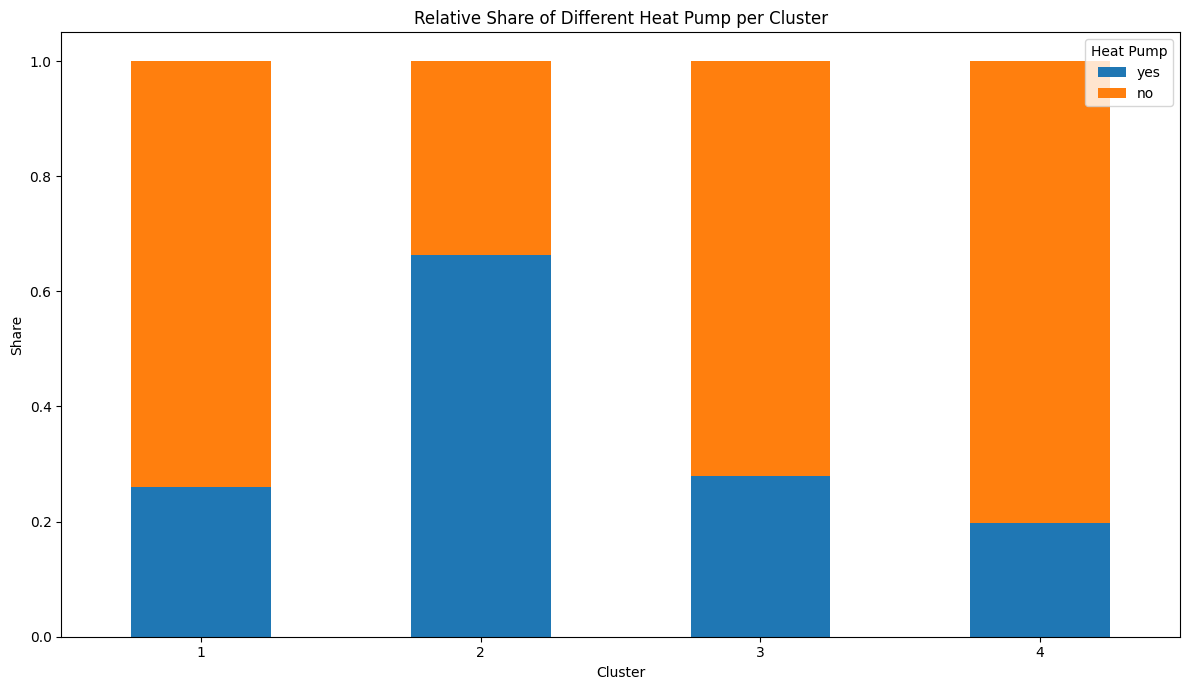

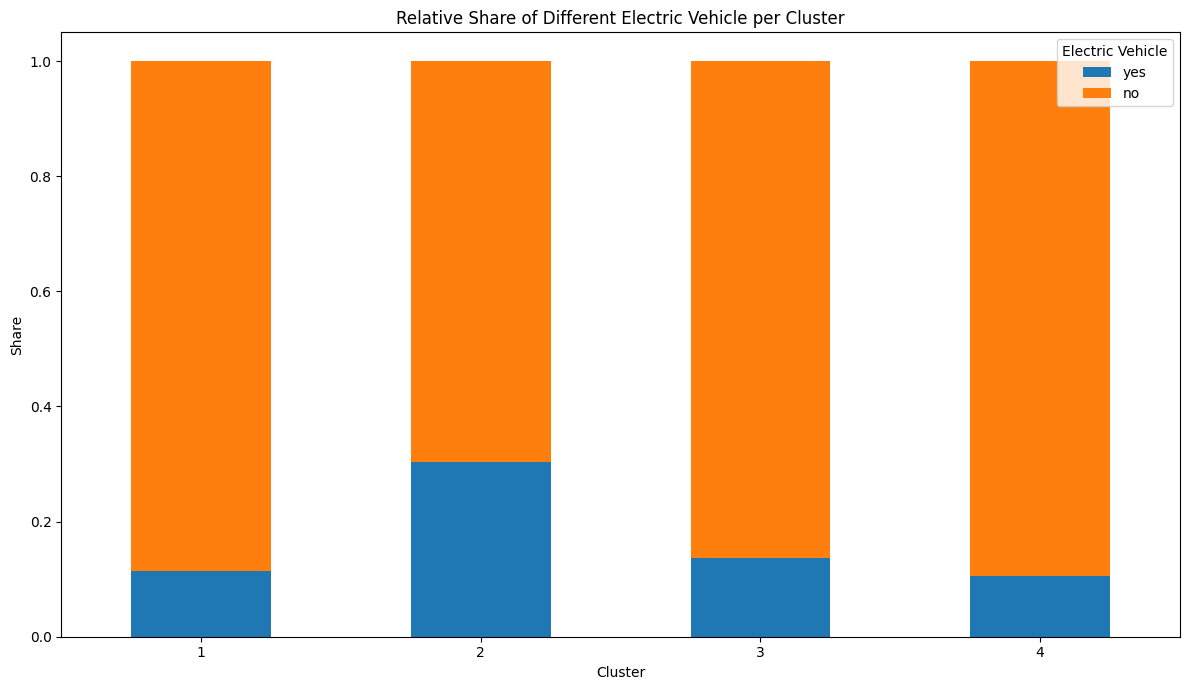

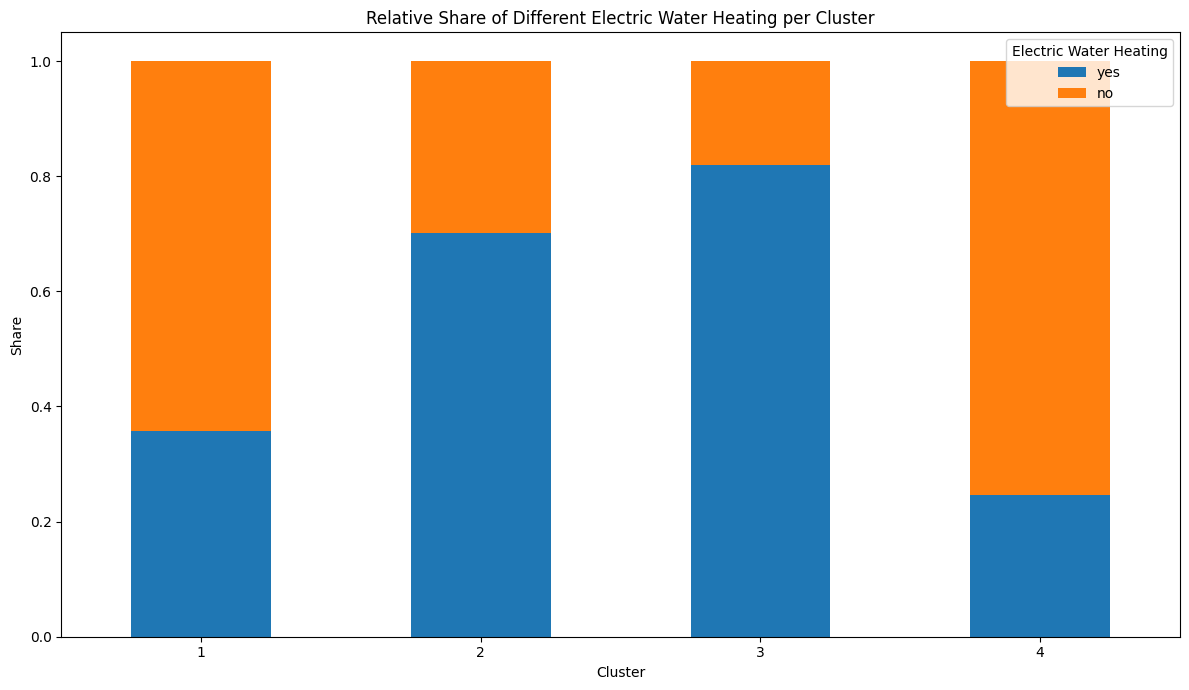

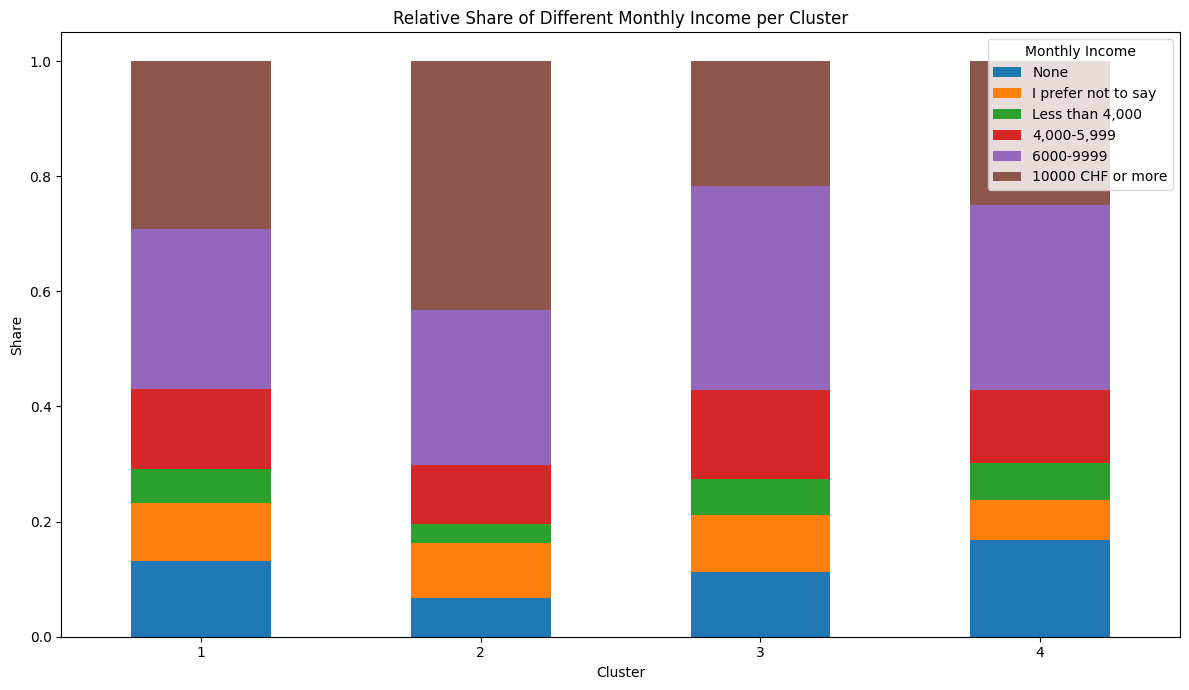

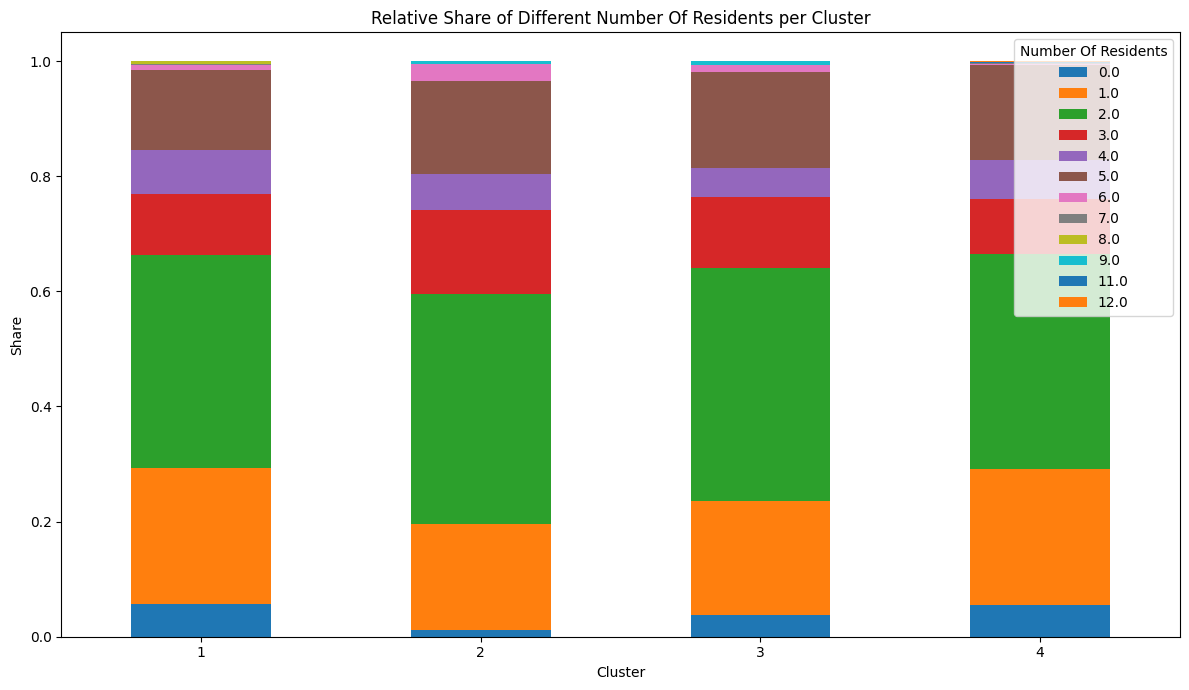

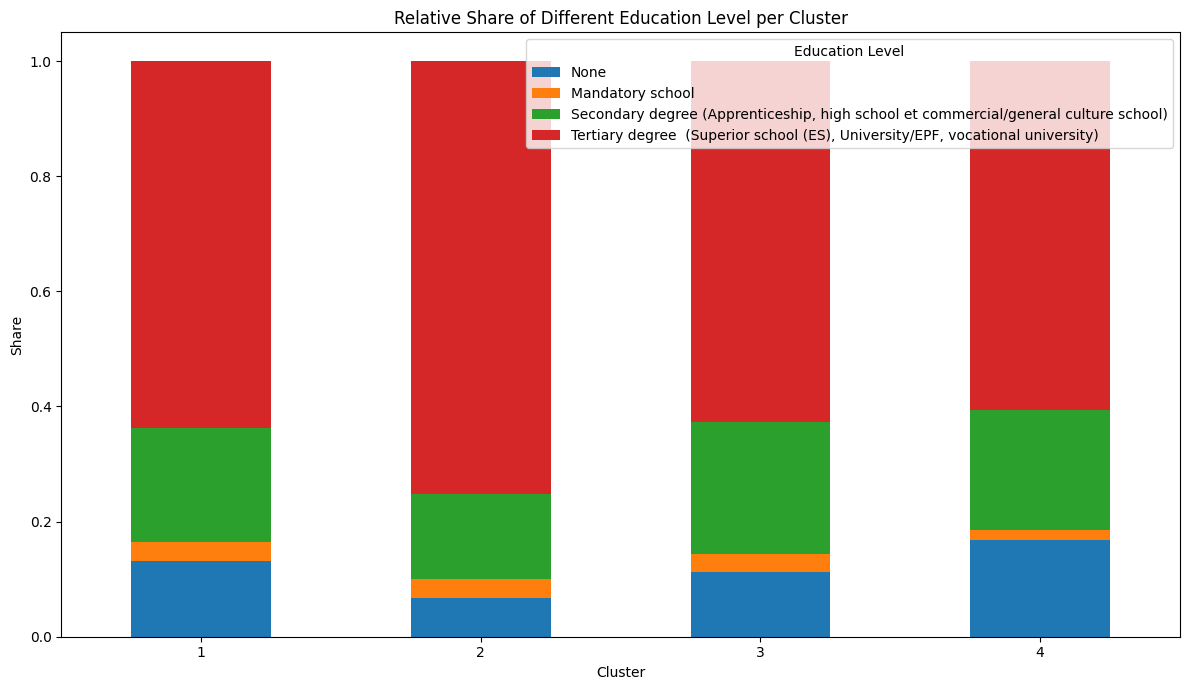

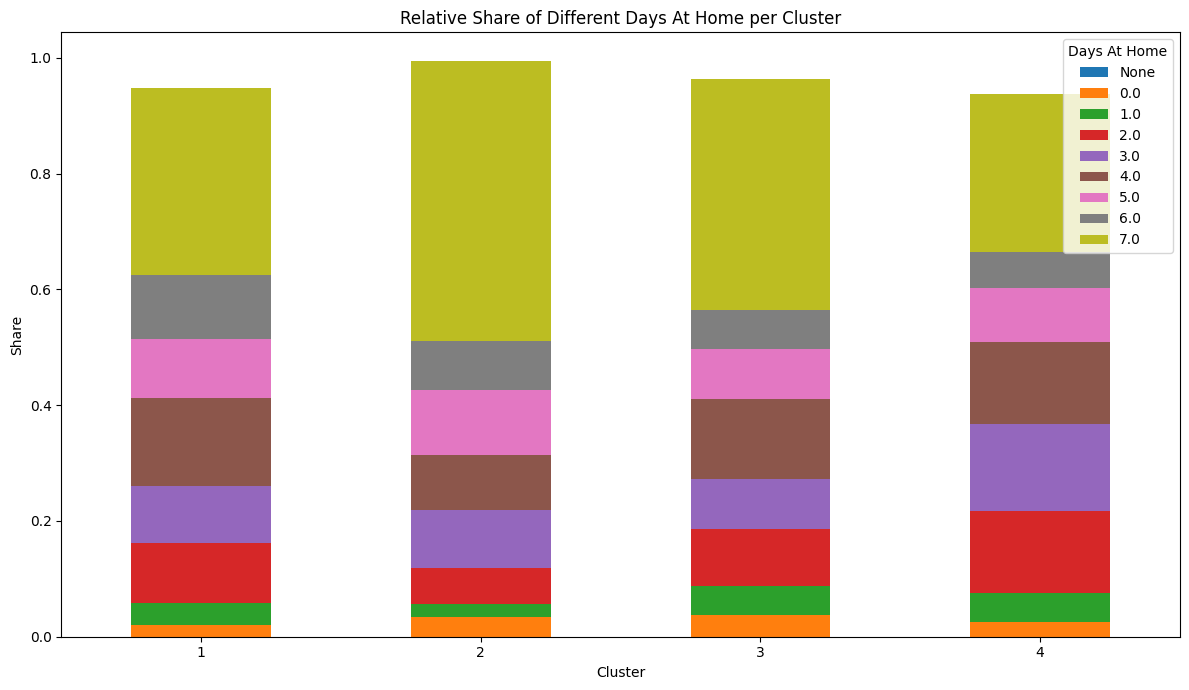

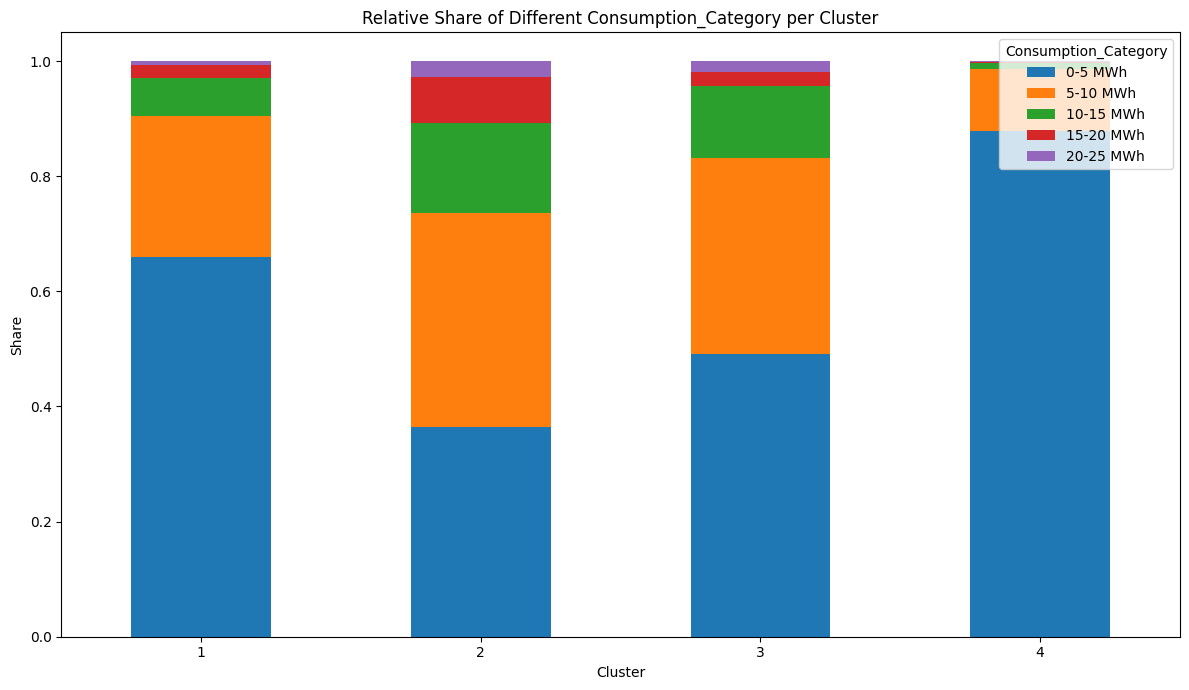

In [21]:
result_folder = Path(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/{data_type}/relative')
result_folder.mkdir(parents=True, exist_ok=True)

final_df_relative = final_df.to_pandas()
clusters = sorted(final_df_relative['cluster'].unique())

cols = final_df_relative.columns[2:]
category_columns = [col for col in cols if col != 'cluster']

for col in category_columns:
    final_df_relative[col] = final_df_relative[col].astype(str)
    unique_cats = set(final_df_relative[col].unique())

    # Retrieve full fixed order for the column
    fixed_category_order = custom_category_orders.get(col)
    if fixed_category_order is None:
        # If no order provided, fall back to alphabetical (or raise error)
        fixed_category_order = sorted(unique_cats)

    # Optionally, check that fixed_category_order matches actual categories exactly
    #if set(fixed_category_order) != unique_cats:
        #raise ValueError(f"Category order for '{col}' does not match unique categories in data.")

    counts = {cat: [] for cat in fixed_category_order}

    for cl in clusters:
        cluster_subset = final_df_relative[final_df_relative['cluster'] == cl]
        total_in_cluster = len(cluster_subset)
        for cat in fixed_category_order:
            count_cat = sum(cluster_subset[col] == cat)
            prop_cat = count_cat / total_in_cluster if total_in_cluster > 0 else 0
            counts[cat].append(prop_cat)

    prop_df = pd.DataFrame(counts, index=clusters)

    ax = prop_df.plot(kind='bar', stacked=True, figsize=(12, 7))
    ax.set_title(f"Relative Share of Different {col.title()} per Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Share")
    ax.legend(title=col.title(), loc='upper right')
    plt.xticks(rotation=0)
    plt.tight_layout()
    filename = f'{data_type}_{col}_relative.png'
    full_path = os.path.join(result_folder, filename)

    plt.savefig(full_path)
    plt.show()

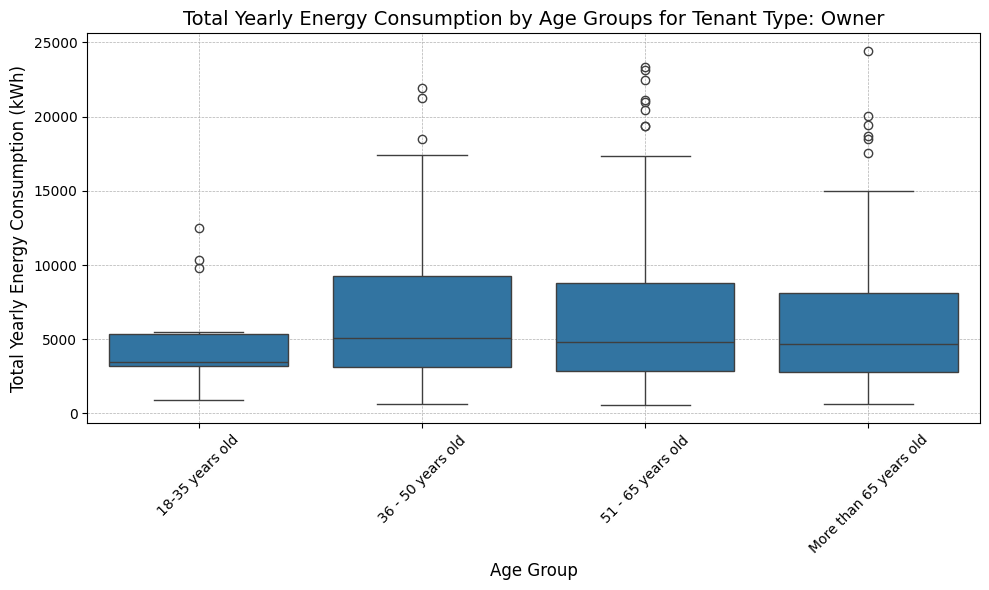

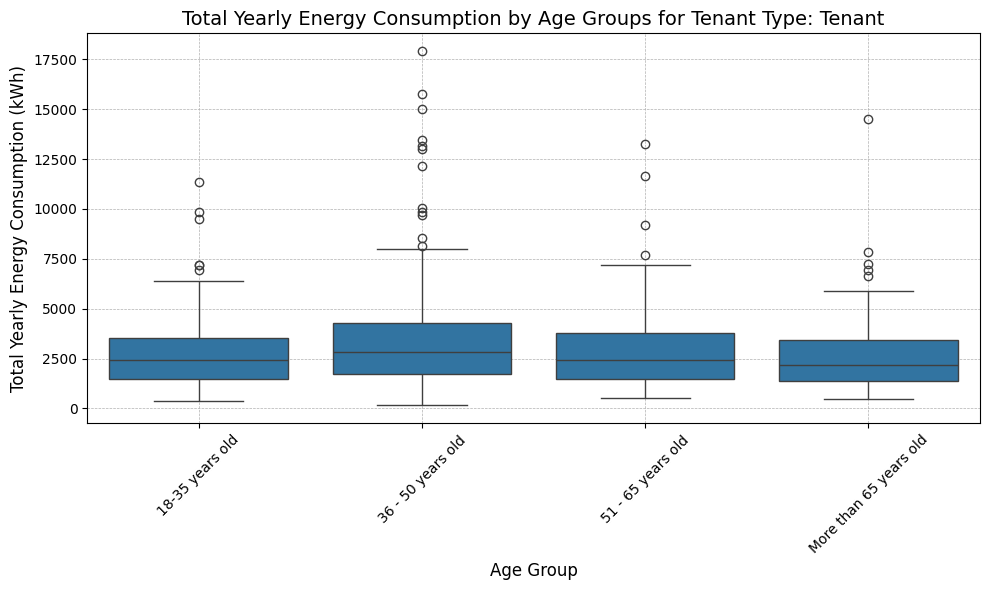

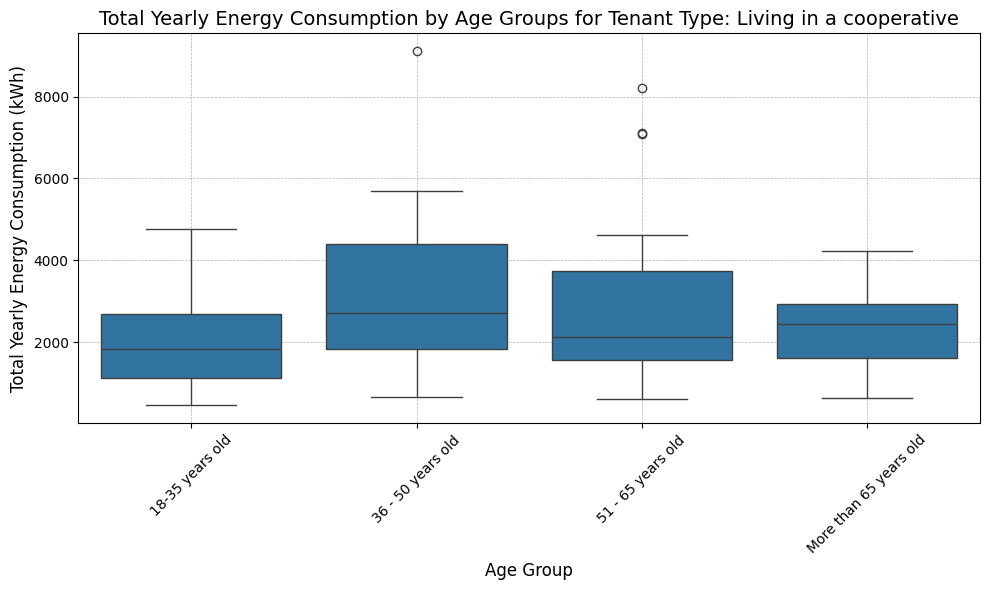

In [22]:
# Assuming final_df_absolut contains the relevant columns: 'tenant type', 'age', 'bruttolastgang_kwh_sum'

tenant_type_order = [
    'Owner',
    'Tenant',
    'Living in a cooperative'
]

age_order = [
    '18-35 years old',
    '36 - 50 years old',
    '51 - 65 years old',
    'More than 65 years old'
]

for tenant_type in tenant_type_order:
    plot_df = final_df_absolute[
        (final_df_absolute['tenant type'] == tenant_type) &
        (final_df_absolute['age'].isin(age_order))
    ]
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=plot_df, x='age', y='bruttolastgang_kwh_sum', order=age_order)
    
    plt.title(f'Total Yearly Energy Consumption by Age Groups for Tenant Type: {tenant_type}', fontsize=14)
    plt.xlabel('Age Group', fontsize=12)
    plt.ylabel('Total Yearly Energy Consumption (kWh)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()